In [1]:
%matplotlib inline


import pydicom as dicom
import matplotlib.pylab as plt

import os
import numpy as np

In [2]:
def load_CT(PATH):
    slices = [dicom.dcmread(PATH + '/' + s) for s in os.listdir(PATH)]
    return slices
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    image = image.astype(np.int16)
    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [3]:
FOLDER_PATH = "E:/Egyetem/AI/_Orvosi képfeldolgozás/Datasets/Berci_mellkas/"
featured_cmaps = ["bone","hot","twilight","PuBuGn","inferno","seismic","hsv","twilight_shifted","spring","Accent","bwr","afmhot"  ]

In [4]:
CT_dicom = load_CT(FOLDER_PATH)
CT_kepsorozat = get_pixels_hu(CT_dicom)

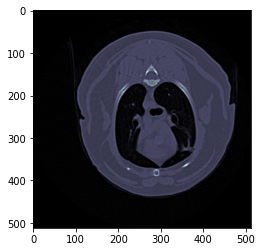

In [14]:
plt.imshow(CT_kepsorozat[0], cmap='bone')

In [18]:
from skimage.exposure import histogram

img = copy.deepcopy(CT_kepsorozat[0])

hist, hist_centers = histogram(CT_kepsorozat[0])

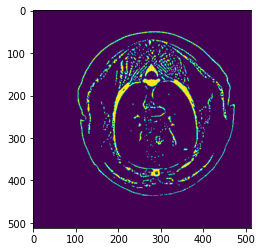

In [22]:
plt.imshow(img>100)

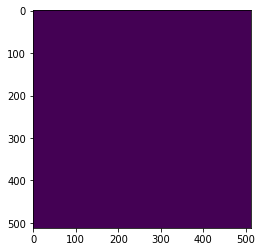

In [24]:
from skimage.feature import canny

edges = canny(CT_kepsorozat[0])

plt.imshow(edges)

In [25]:
import copy

segM = copy.deepcopy(CT_kepsorozat[12])

segM2 = copy.deepcopy(CT_kepsorozat[12])

<ipython-input-26-df711d154179>:4: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  gray = rgb2gray(segM)


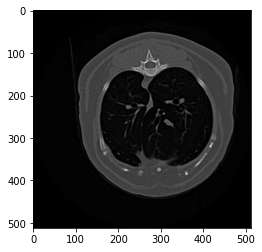

In [26]:
from skimage.color import rgb2gray


gray = rgb2gray(segM)
plt.imshow(gray, cmap='gray')

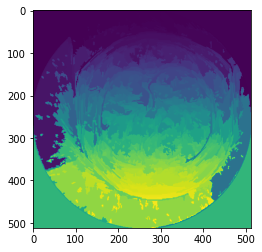

In [27]:
import skimage.segmentation as seg


image_felzenszwalb = seg.felzenszwalb(segM2) 
plt.imshow(image_felzenszwalb)

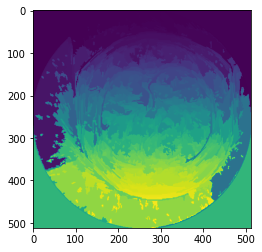

In [29]:
image_felzenszwalb = seg.felzenszwalb(segM) 
plt.imshow(image_felzenszwalb)

<ipython-input-30-8ab2d40eafc3>:3: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  image_felzenszwalb_colored = color.label2rgb(image_felzenszwalb, segM, kind='avg')


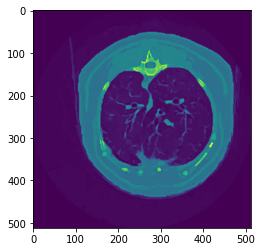

In [30]:
import skimage.color as color

image_felzenszwalb_colored = color.label2rgb(image_felzenszwalb, segM, kind='avg')
plt.imshow(image_felzenszwalb_colored)

In [37]:
#segmentation:
from skimage import measure, morphology
from skimage.morphology import ball, binary_closing
from skimage.measure import label, regionprops
import cv2
import scipy


def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)
    counts = counts[vals != bg]
    vals = vals[vals != bg]
    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None
def segment_lung_mask(image, fill_lung_structures=True):
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image >= -700, dtype=np.int8)+1
    labels = measure.label(binary_image)
    background_label = labels[0,0,0]
 
    # Fill the air around the person
    binary_image[background_label == labels] = 2
 
    # Method of filling the lung structures (that is superior to 
    # something like morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
 
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
 
    # Remove other air pockets inside body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
        
    plt.imshow(binary_image[2])
 
    return binary_image

def total_lung_MASK(img):
    return 1-scipy.ndimage.filters.gaussian_filter(1-img, 0.7, order=0, output=None, mode='reflect', cval=0.7, truncate=7.0)

def get_internal_structures(dataset):
    segmented_lung = segment_lung_mask(dataset, fill_lung_structures=False)
    return total_lung_MASK(segmented_lung)-segmented_lung

In [38]:
internal = get_internal_structures(image_felzenszwalb_colored)

plt.imshow(internal, cmap=plt.cm.bone)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

TypeError: Invalid shape (512,) for image data

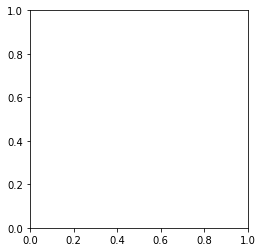

-987
0


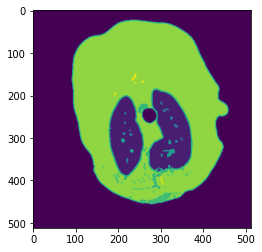

In [30]:
print(image_felzenszwalb_colored[1][10])
arr = image_felzenszwalb_colored
new_arr = ((arr - arr.min()) * (1/(arr.max() - arr.min()) * 255)).astype('uint8')

print(new_arr[135][3])
plt.imshow(new_arr)

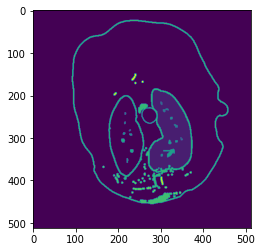

In [29]:
w = seg.flood_fill(new_arr,(0, 0),0)
w = seg.flood_fill(w,(176, 176),0)
w = seg.flood_fill(w,(212, 212),0)

plt.imshow(w)

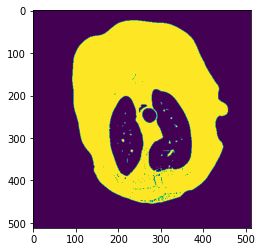

In [31]:
w = seg.flood_fill(gray,(0, 0),0)
plt.imshow(w)

In [82]:
def print_CT_layers(first,last,dataset,CMAP):
    for i in range(first,last):     
        plt.imshow(dataset[i],cmap=CMAP)
        plt.title(str(i)+". picture with cmap:"+CMAP)
        plt.show()
       # plt.close(fig)

In [83]:
def print_CT_layers_in_table(first,last,dataset,CMAP):
    rows=1 
    columns = 4
    #fig, ax_lst = plt.subplots(2, 2, figsize=(12,8))
    fig = plt.figure(figsize=(30, 30))    
    for i in range(first,last):    
        if((i-first)%4 ==0):
            rows=rows+1;
            fig = plt.figure(figsize=(30, 30))
        fig.add_subplot(1,columns, ((i-first)%4)+1)
        plt.axis('off')
        plt.imshow(dataset[i],cmap=CMAP)
        plt.title(str(i)+".")
    plt.show()
     

In [84]:

def print_CT_layers_segmented(first,last,dataset,CMAP):
    rows=1 
    columns = 4
    #fig, ax_lst = plt.subplots(2, 2, figsize=(12,8))
    fig = plt.figure(figsize=(30, 30))    
    for i in range(first,last):    
        if((i-first)%4 ==0):
            rows=rows+1;
            fig = plt.figure(figsize=(30, 30))
        fig.add_subplot(1,columns, ((i-first)%4)+1)
        plt.axis('off')
        segd2 = np.ma.masked_where(internal_structures[i] <0.1 , internal_structures[i])
        slld = np.ma.masked_where(segmented_lungs[i] <0.1 , segmented_lungs[i])
        plt.imshow(CT_kepsorozat[i], cmap=plt.cm.bone, alpha=0.3)
        plt.imshow(slld, cmap=featured_cmaps[8], interpolation='none', alpha=0.3)
        plt.imshow(segd2, cmap=featured_cmaps[6], interpolation='nearest')
        plt.title(str(i)+".")
    plt.show()
    

In [85]:
#segmentation:
from skimage import measure, morphology
from skimage.morphology import ball, binary_closing
from skimage.measure import label, regionprops

def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)
    counts = counts[vals != bg]
    vals = vals[vals != bg]
    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None
def segment_lung_mask(image, fill_lung_structures=True):
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image >= -700, dtype=np.int8)+1
    labels = measure.label(binary_image)
    background_label = labels[0,0,0]
 
    # Fill the air around the person
    binary_image[background_label == labels] = 2
 
    # Method of filling the lung structures (that is superior to 
    # something like morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
 
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
 
    # Remove other air pockets inside body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

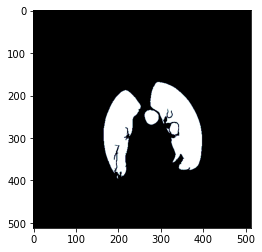

In [86]:
# get masks 
import copy

segmented_lungs = segment_lung_mask(CT_kepsorozat, fill_lung_structures=False)
segmented_lungs_fill = segment_lung_mask(CT_kepsorozat, fill_lung_structures=True)
internal_structures = segmented_lungs_fill - segmented_lungs
# isolate lung from chest
copied_pixels = copy.deepcopy(CT_kepsorozat)
for i, mask in enumerate(segmented_lungs_fill): 
    get_high_vals = mask == 0
    copied_pixels[i][get_high_vals] = 0
seg_lung_pixels = copied_pixels
# sanity check
plt.imshow(segmented_lungs_fill[123], cmap=plt.cm.bone)

In [87]:
def segment_lung_mask2(image, fill_lung_structures=True):
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image >= -700, dtype=np.int8)+1
    labels = measure.label(binary_image)
    background_label = labels[0,0,0]
 
    # Fill the air around the person
    binary_image[background_label == labels] = 2
 
    # Method of filling the lung structures (that is superior to 
    # something like morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
 
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

 
    return binary_image

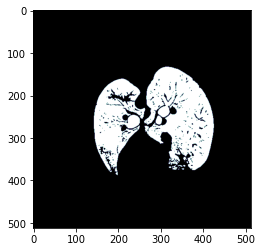

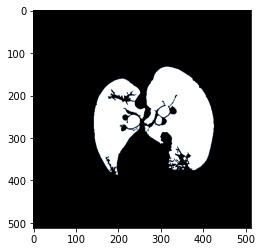

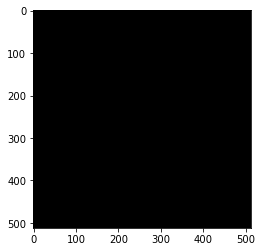

In [88]:

segmented_lungs_fill2 = segment_lung_mask2(segmented_lungs_fill, fill_lung_structures=True)
plt.figure(1)
plt.imshow(segmented_lungs[169], cmap=plt.cm.bone)
plt.figure(2)
plt.imshow(segmented_lungs_fill[169], cmap=plt.cm.bone)

plt.figure(3)
plt.imshow(segmented_lungs_fill2[169], cmap=plt.cm.bone)

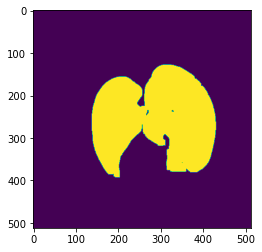

In [89]:
import cv2
import scipy
mask = 1-segmented_lungs_fill[169]

mask = 1-scipy.ndimage.filters.gaussian_filter(mask, 0.7, order=0, output=None, mode='reflect', cval=0.7, truncate=7.0)
plt.imshow(mask)

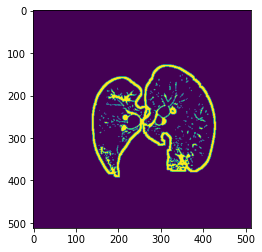

In [90]:
plt.imshow(mask-segmented_lungs[169])

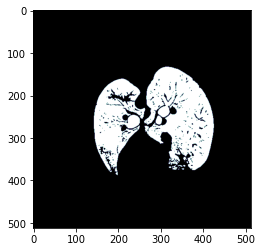

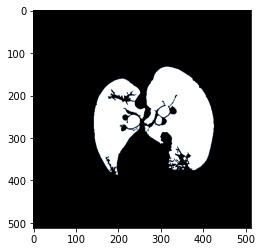

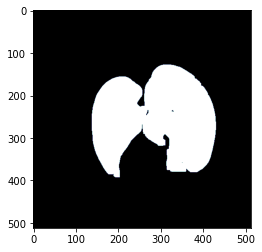

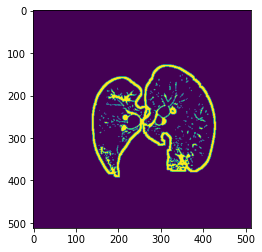

In [77]:
plt.figure(1)
plt.imshow(segmented_lungs[169], cmap=plt.cm.bone)
plt.figure(2)
plt.imshow(segmented_lungs_fill[169], cmap=plt.cm.bone)
plt.figure(3)
plt.imshow(mask, cmap=plt.cm.bone)
plt.figure(4)
plt.imshow(mask-segmented_lungs[169])

<Figure size 2160x2160 with 0 Axes>

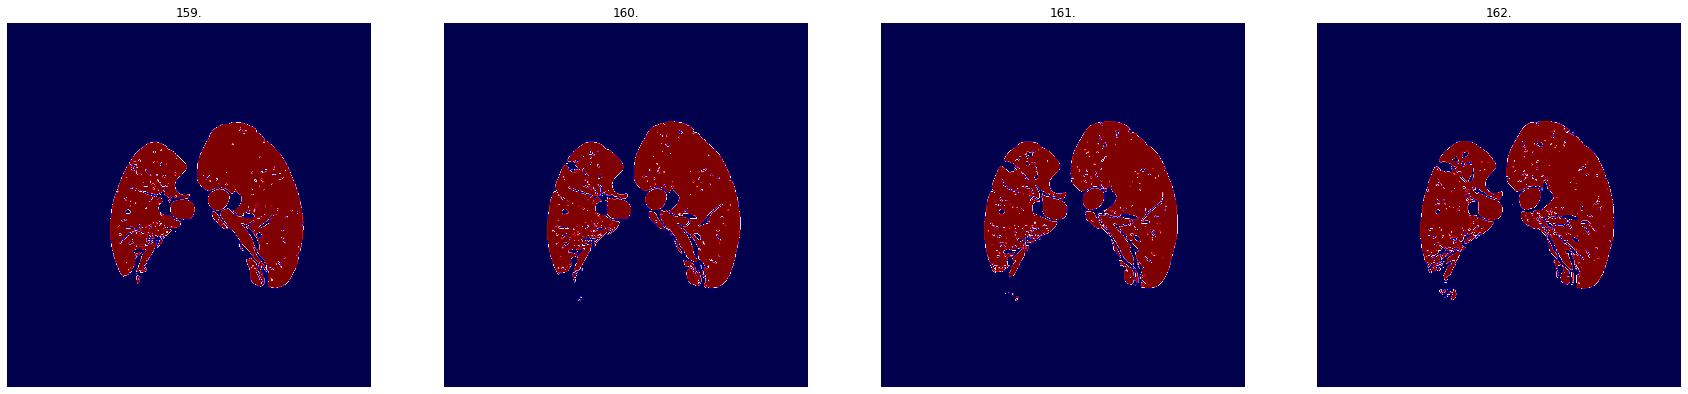

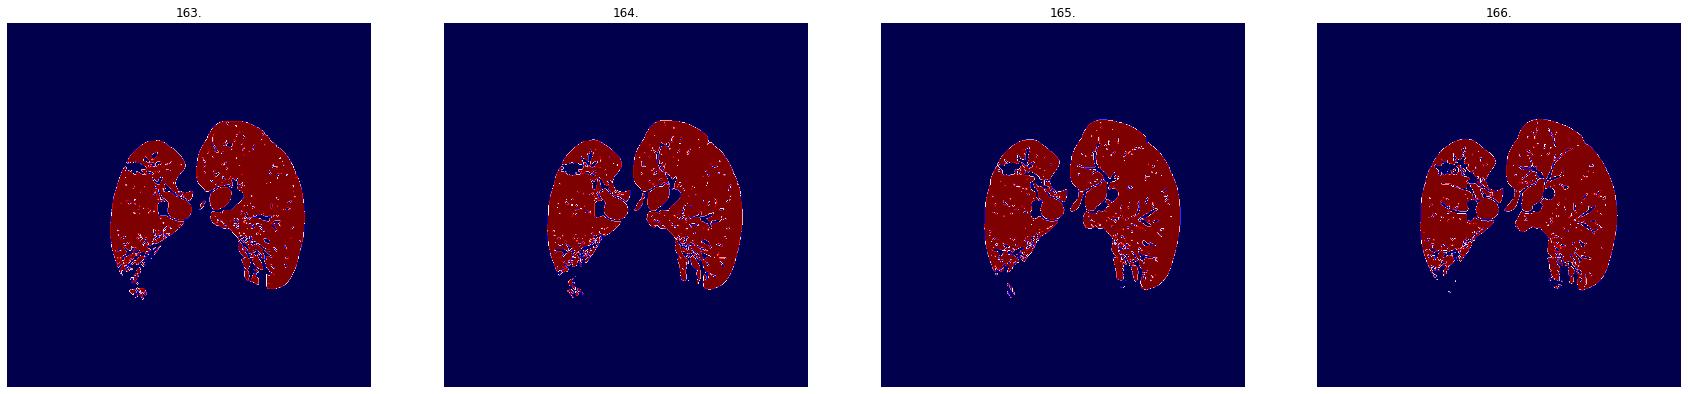

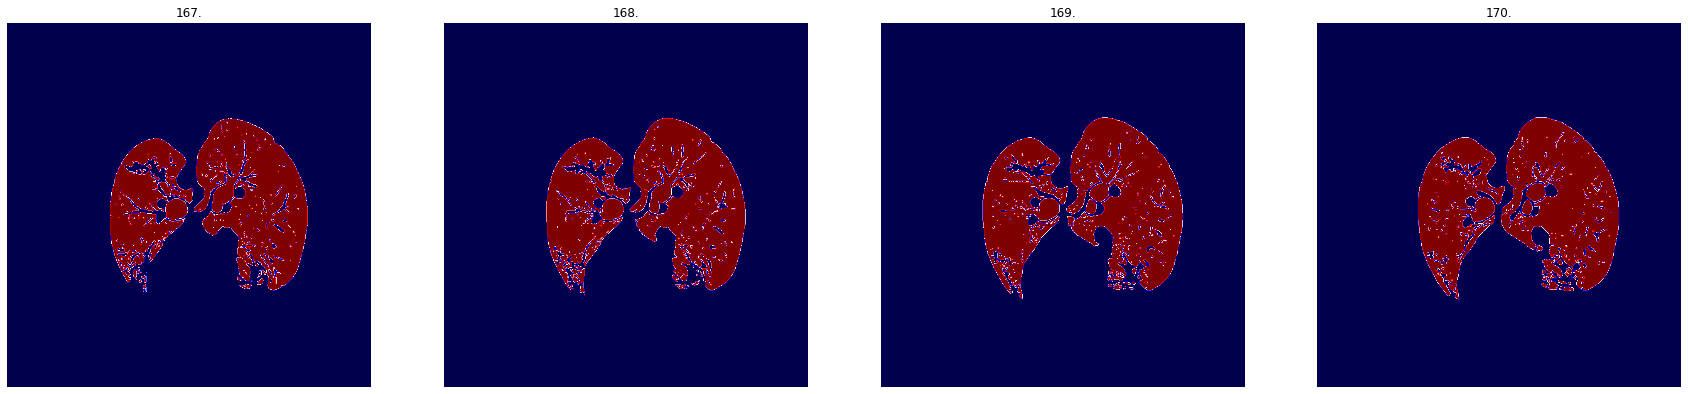

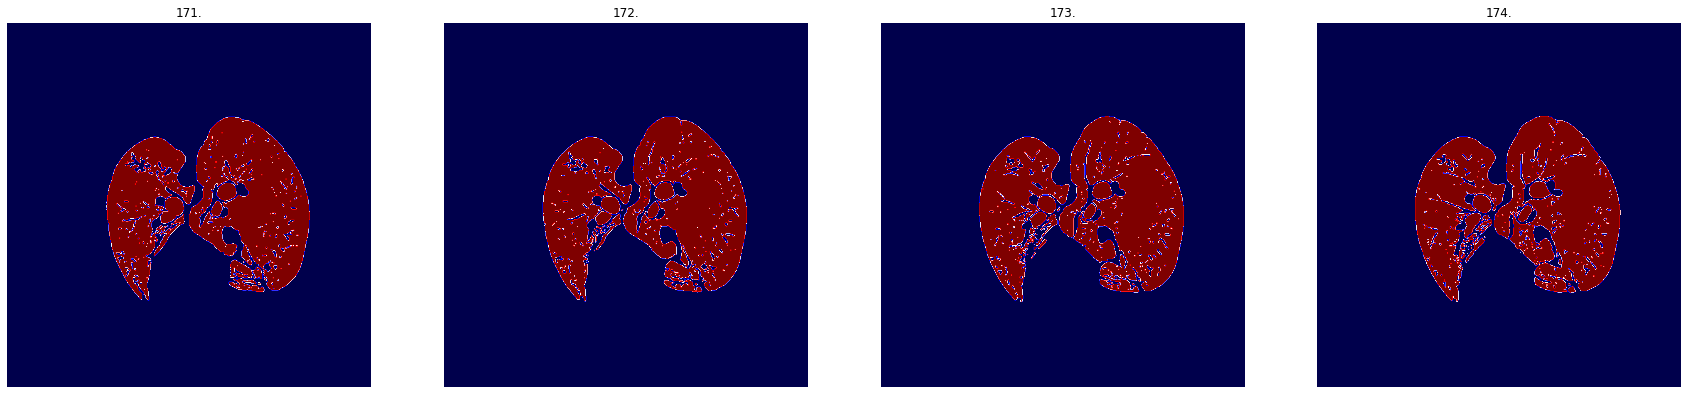

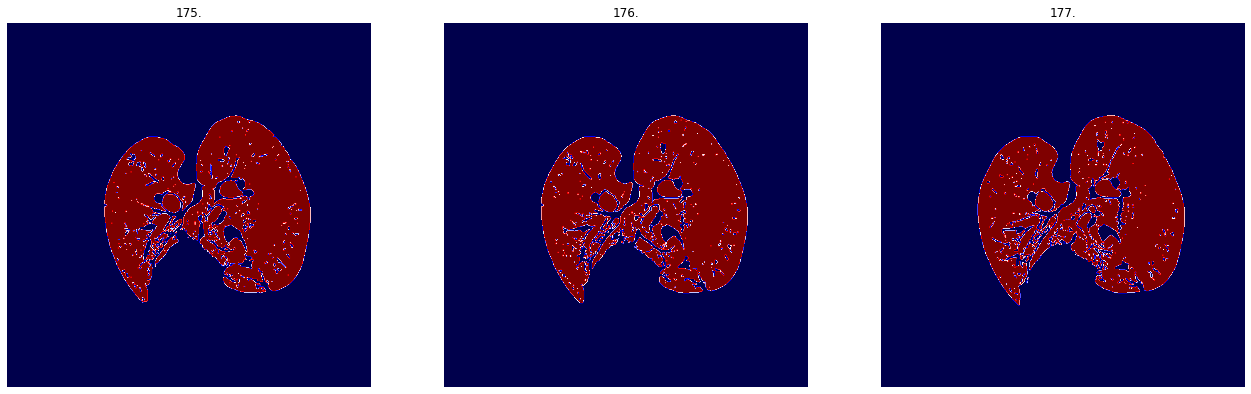

In [204]:
print_CT_layers_in_table(159,178,segmented_lungs,featured_cmaps[5])

<Figure size 2160x2160 with 0 Axes>

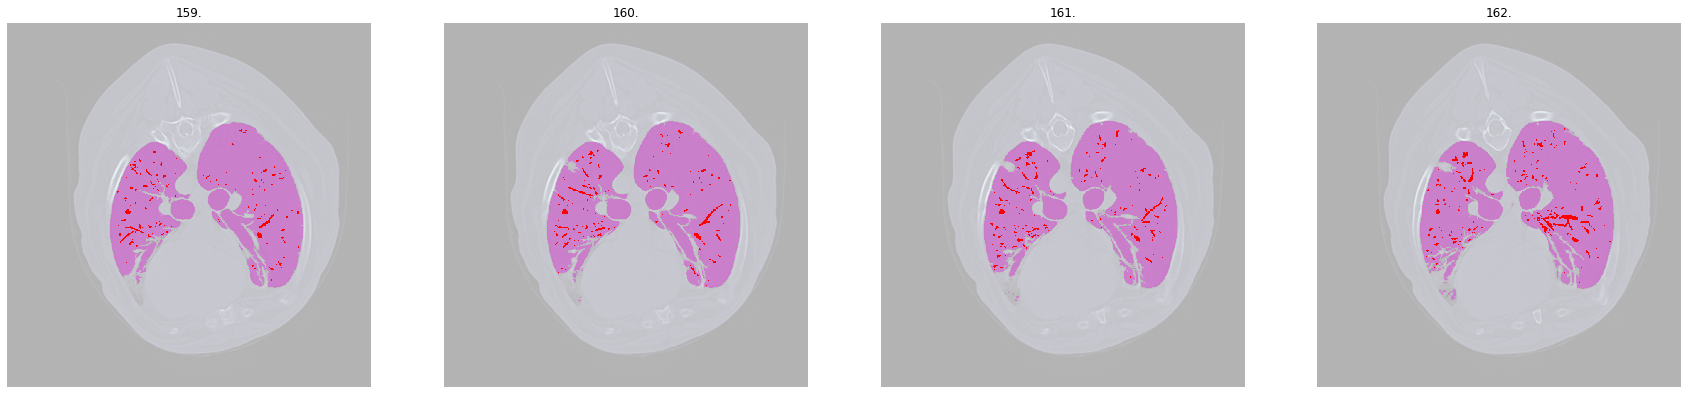

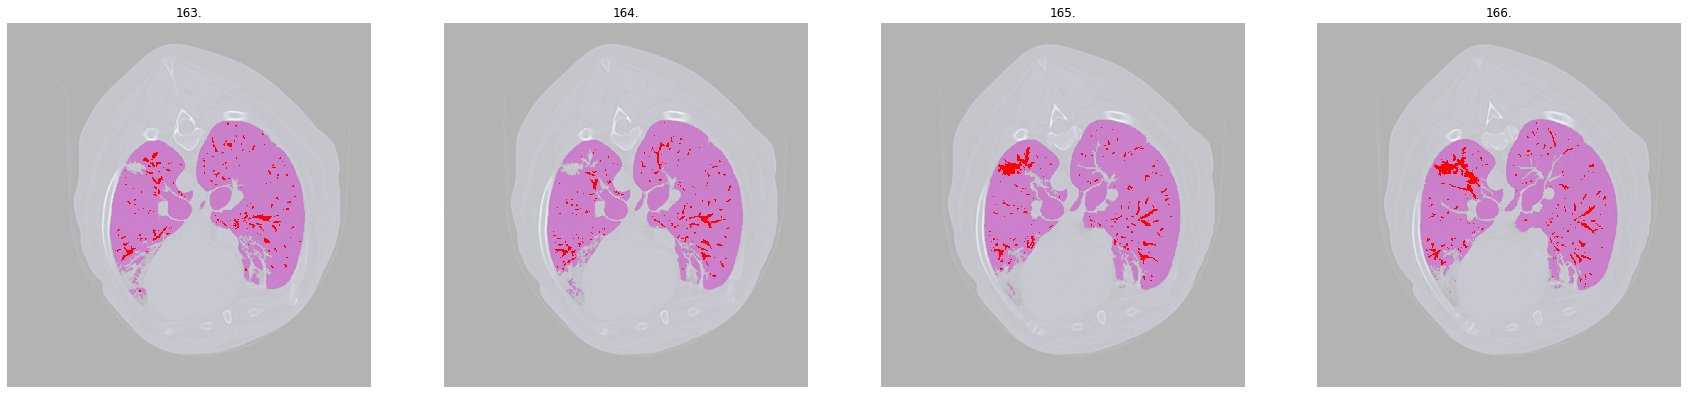

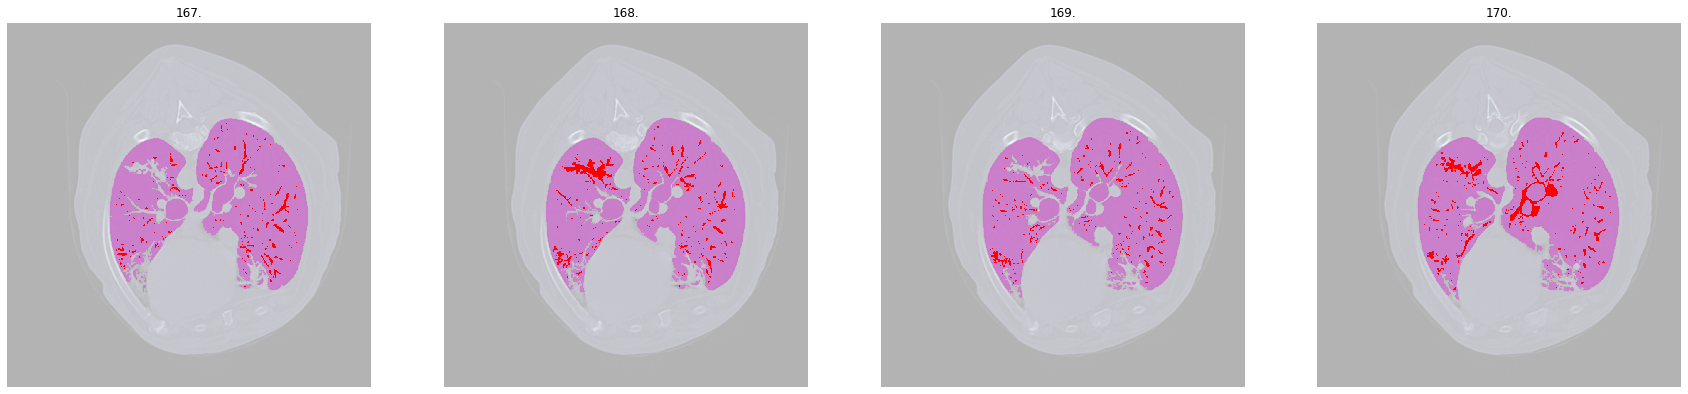

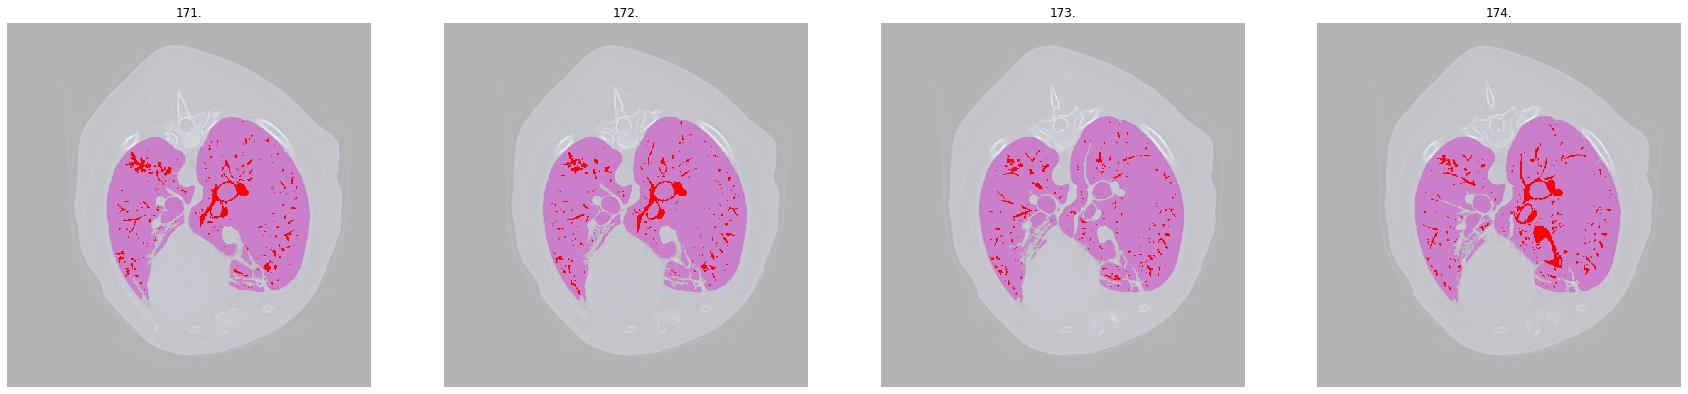

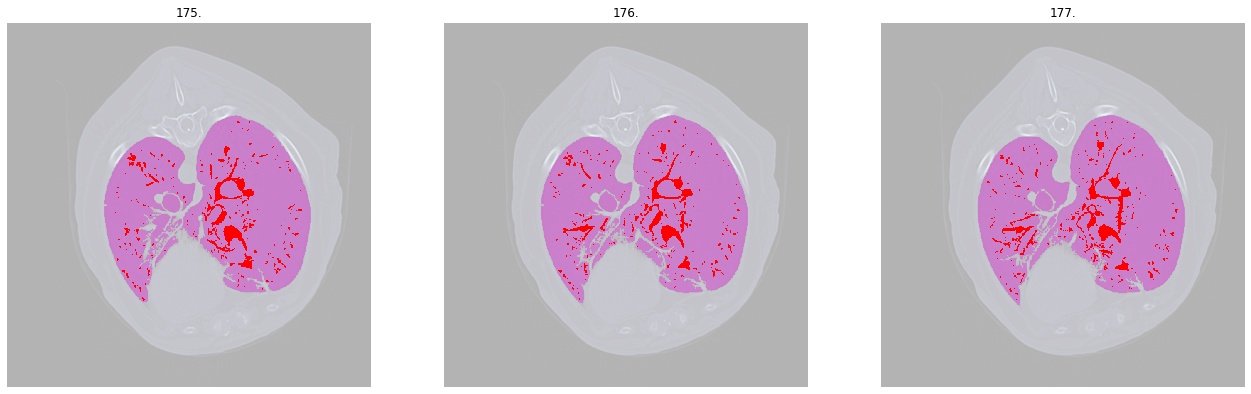

In [205]:
print_CT_layers_segmented(159,178,CT_kepsorozat,featured_cmaps[5])

In [183]:
main = CT_kepsorozat[169]
seg = internal_structures[169]
seg2 =internal_structures[169]
img = CT_kepsorozat[169]
imgf = CT_kepsorozat[169]
sll = segmented_lungs[169]
sl = seg_lung_pixels[169]

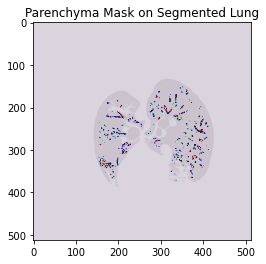

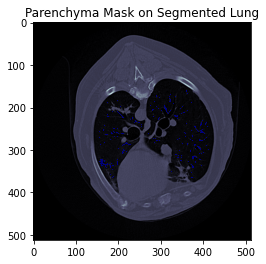

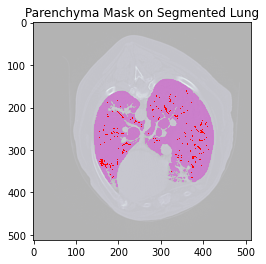

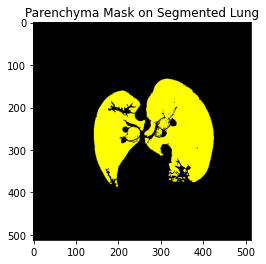

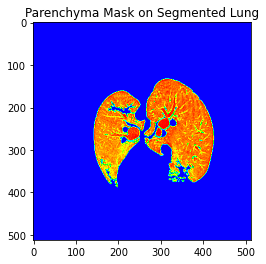

In [197]:
from skimage import segmentation
import cv2

slice_id = 169

segd = np.ma.masked_where(seg < 0.6, seg)

#result_image = segmentation.mark_boundaries(seg,seg, mode='thick')
segd2 = np.ma.masked_where(seg <0.1 , seg)

slld = np.ma.masked_where(sll <0.1 , sll)


plt.figure(1)
plt.title('Parenchyma Mask on Segmented Lung')
plt.imshow(seg_lung_pixels[slice_id], cmap=plt.cm.bone)
plt.imshow(seg, cmap=featured_cmaps[2],alpha=0.9)


plt.figure(2)
plt.title('Parenchyma Mask on Segmented Lung')
plt.imshow(CT_kepsorozat[169], cmap=plt.cm.bone)
plt.imshow(segd, cmap='jet', interpolation='nearest')

plt.figure(3)
plt.title('Parenchyma Mask on Segmented Lung')
plt.imshow(CT_kepsorozat[169], cmap=plt.cm.bone, alpha=0.3)
plt.imshow(slld, cmap=featured_cmaps[8], interpolation='none', alpha=0.3)
plt.imshow(segd2, cmap=featured_cmaps[6], interpolation='nearest')

sl = seg_lung_pixels[slice_id]
result_image = segmentation.mark_boundaries(sl,sl, mode='inner')
segd3 = np.ma.masked_where(result_image <0.9 , result_image)

plt.figure(4)
plt.title('Parenchyma Mask on Segmented Lung')
plt.imshow(CT_kepsorozat[169], cmap=plt.cm.bone)
plt.imshow(segd3, cmap=featured_cmaps[6])


plt.figure(5)
plt.title('Parenchyma Mask on Segmented Lung')
plt.imshow(CT_kepsorozat[169], cmap=plt.cm.bone)
plt.imshow(sl, cmap=featured_cmaps[6])


In [159]:
print(segd3[152])



[[-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [-- -- --]
 [--

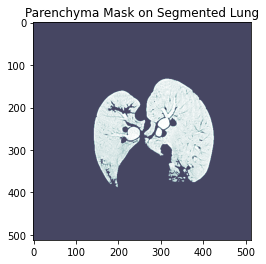

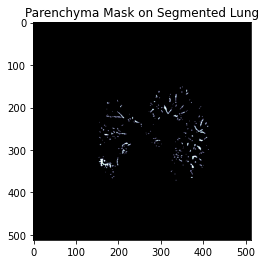

In [134]:
plt.figure(1)
plt.title('Parenchyma Mask on Segmented Lung')
plt.imshow(1-seg_lung_pixels[slice_id], cmap=plt.cm.bone)


plt.figure(2)
plt.title('Parenchyma Mask on Segmented Lung')
plt.imshow(internal_structures[169], cmap=plt.cm.bone)

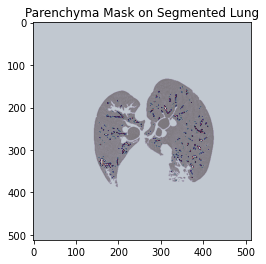

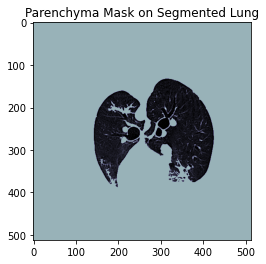

In [42]:
slice_id = 169

plt.figure(1)
plt.title('Parenchyma Mask on Segmented Lung')
plt.imshow(seg_lung_pixels[slice_id], cmap=plt.cm.bone,alpha=0.9)
plt.imshow(internal_structures[slice_id], cmap=featured_cmaps[2], vmin = 0, vmax=1,alpha=0.5)


plt.figure(2)
plt.title('Parenchyma Mask on Segmented Lung')
plt.imshow(internal_structures[slice_id], cmap=featured_cmaps[2],vmin = 0.5, vmax=0.6,alpha=0.5)
plt.imshow(seg_lung_pixels[slice_id], cmap=plt.cm.bone)


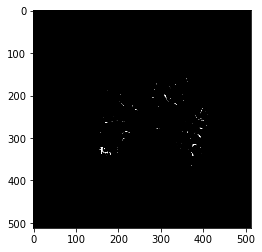

In [29]:
plt.imshow(internal_structures[slice_id], cmap="gray", vmin = 0.5, vmax=0.9)

In [16]:
print(internal_structures[slice_id][152])
print(seg_lung_pixels[slice_id][152])


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [185]:
#print_CT_layers_in_table(159,178,internal_structures+0.5,plt.cm.bone)

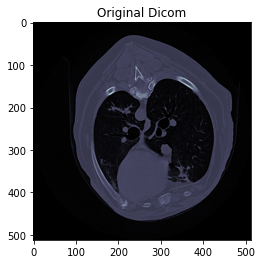

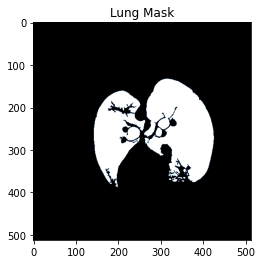

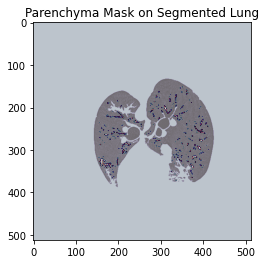

In [193]:
# pick random slice 
slice_id = 169
plt.figure(1)
plt.title('Original Dicom')
plt.imshow(CT_kepsorozat[slice_id], cmap=plt.cm.bone)
plt.figure(2)
plt.title('Lung Mask')
plt.imshow(segmented_lungs_fill[slice_id], cmap=plt.cm.bone)
plt.figure(3)
plt.title('Parenchyma Mask on Segmented Lung')
plt.imshow(seg_lung_pixels[slice_id], cmap=plt.cm.bone)
plt.imshow(internal_structures[slice_id], cmap=featured_cmaps[2],alpha=0.5)

In [186]:
main = CT_kepsorozat[169]
seg = internal_structures[169]
seg2 =internal_structures[169]
img = CT_kepsorozat[169]

(512, 512)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0

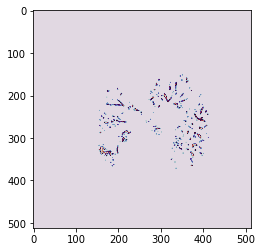

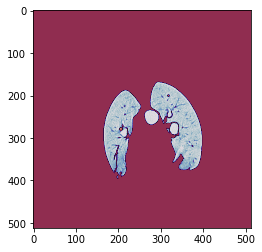

In [187]:
print(seg.shape)
print(seg[152])
plt.imshow(seg, cmap="twilight")
plt.show()
plt.imshow(seg_lung_pixels[123], cmap="twilight")
plt.show()


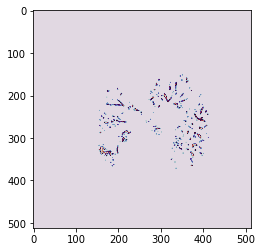

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

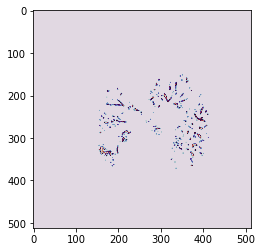

In [188]:
plt.imshow(seg, cmap="twilight")
plt.show()

for i in range(512):
    for j in range(512):
        if(seg[i][j]==1):
            seg[i][j]=3
plt.imshow(seg, cmap="twilight")
print(seg[152])
plt.show()

In [175]:
from PIL import Image, ImageEnhance
img1 = Image.composite(main, main,seg)
plt.imshow(img1)

AttributeError: 'numpy.ndarray' object has no attribute 'paste'

In [66]:
result = cv2.add(main, seg)

error: OpenCV(4.5.1) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-kh7iq4w7\opencv\modules\core\src\arithm.cpp:693: error: (-5:Bad argument) When the input arrays in add/subtract/multiply/divide functions have different types, the output array type must be explicitly specified in function 'cv::arithm_op'


In [54]:
import numpy as np
import cv2

# Load images as greyscale but make main RGB so we can annotate in colour
#seg  = cv2.imread('segmented.png',cv2.IMREAD_GRAYSCALE)
#main = cv2.imread('main.png',cv2.IMREAD_GRAYSCALE)

#seg =
# Dictionary giving RGB colour for label (segment label) - label 1 in red, label 2 in yellow
RGBforLabel = { 1:(0,0,255), 2:(0,255,255) }

# Find external contours
_contours,_= cv2.findContours(seg,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)

# Iterate over all contours
for i,c in enumerate(contours):
    # Find mean colour inside this contour by doing a masked mean
    mask = np.zeros(seg.shape, np.uint8)
    cv2.drawContours(mask,[c],-1,255, -1)
    # DEBUG: cv2.imwrite(f"mask-{i}.png",mask)
    plt.imshow(mask)
    mean,_,_,_ = cv2.mean(seg, mask=mask)
    # DEBUG: print(f"i: {i}, mean: {mean}")

    # Get appropriate colour for this label
    label = 2 if mean > 1.0 else 1
    colour = RGBforLabel.get(label)
    # DEBUG: print(f"Colour: {colour}")

    # Outline contour in that colour on main image, line thickness=1
    cv2.drawContours(main,[c],-1,colour,1)

# Save result
plt.imshow(main)

error: OpenCV(4.5.1) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-kh7iq4w7\opencv\modules\imgproc\src\contours.cpp:197: error: (-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'


In [33]:
cv2.drawContours(img, seg, -1, (0,255,0), 3)

error: OpenCV(4.5.1) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-kh7iq4w7\opencv\modules\imgproc\src\drawing.cpp:2501: error: (-215:Assertion failed) npoints > 0 in function 'cv::drawContours'


In [21]:
from skimage import io, color
import matplotlib.pyplot as plt
import numpy as np

seg = np.zeros((256,256)) # create a matrix of zeroes of same size as image
seg[gt > 0.95] = 1   # Change zeroes to label "1" as per your condition(s)
seg[zz == 255] = 2   

io.imshow(color.label2rgb(seg,img,colors=[(255,0,0),(0,0,255)],alpha=0.01, bg_label=0, bg_color=None))
plt.show()

NameError: name 'gt' is not defined

<ipython-input-25-157251ea3d6b>:2: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  result_image = color.label2rgb(seg, img)
E:\PROGRAM\Anaconda\lib\site-packages\skimage\color\colorlabel.py:113: UserWarning: Negative intensities in `image` are not supported
  return _label2rgb_overlay(label, image, colors, alpha, bg_label,
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


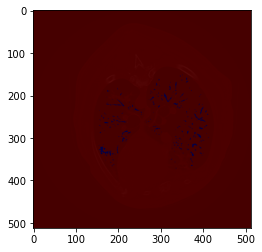

In [25]:
from skimage import color
result_image = color.label2rgb(seg, img)
plt.imshow(result_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


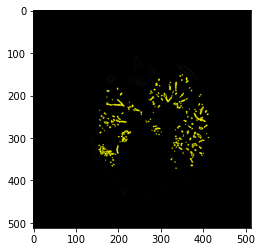

In [27]:
imgray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(imgray,127,255,0)
contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
plt.imshow(contours)

error: OpenCV(4.5.1) c:\users\appveyor\appdata\local\temp\1\pip-req-build-kh7iq4w7\opencv\modules\imgproc\src\color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0x206ccf44::Set<1,-1,-1>,struct cv::impl::A0x206ccf44::Set<0,2,5>,2>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


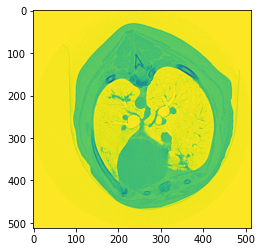

In [50]:
seg = np.asarray(seg, np.float64)
img = np.asarray(img, np.float64)


green_hair_w = cv2.addWeighted(seg, 0.9, 1-img, 0.9, 0, seg)


plt.imshow(green_hair_w)

In [82]:
import pandas as pd
mrg = pd.merge(seg_lung_pixels[12],internal_structures[12])
plt.imshow(mrg)

TypeError: Can only merge Series or DataFrame objects, a <class 'numpy.ndarray'> was passed

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


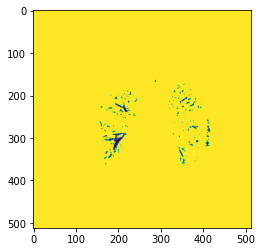

In [83]:
plt.imshow(1-internal_structures[155])
#plt.imshow(internal_structures[155])
print(1-internal_structures[155])

img = internal_structures[155]
img = img-0.8
plt.imshow(1-img)

In [58]:
full = (seg_lung_pixels[155]=[255,0,26])




plt.imshow(full,plt.cm.bone)

SyntaxError: invalid syntax (<ipython-input-58-e1699d0bb971>, line 1)

In [84]:
from PIL import Image
from PIL import ImageDraw

result = Image.blend((seg_lung_pixels[12],internal_structures[12], alpha=0.5)
plt.imshow(result,plt.cm.bone)

SyntaxError: invalid syntax (<ipython-input-84-91b49a573f3e>, line 4)

In [86]:
import cv2
from matplotlib import pyplot as plt

img = seg_lung_pixels[12]
edges = cv2.Canny(img,50,200)   # canny edge detector

img = cv2.merge((img,img,img))  # creat RGB image from grayscale
img2 = img.copy()
img2[edges == 255] = [255, 0, 0]  # turn edges to red

plt.subplot(121),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img2)
plt.title('Edge Highlighted'), plt.xticks([]), plt.yticks([])

plt.show()

error: OpenCV(4.5.1) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-kh7iq4w7\opencv\modules\imgproc\src\canny.cpp:829: error: (-215:Assertion failed) _src.depth() == CV_8U in function 'cv::Canny'


In [87]:
from skimage import io, color
import matplotlib.pyplot as plt
import numpy as np

seg = np.zeros((256,256)) # create a matrix of zeroes of same size as image
seg[gt > 0.95] = 1   # Change zeroes to label "1" as per your condition(s)
seg[zz == 255] = 2   

io.imshow(color.label2rgb(seg_lung_pixels,CT_kepsorozat,colors=[(255,0,0),(0,0,255)],alpha=0.01, bg_label=0, bg_color=None))
plt.show()

NameError: name 'gt' is not defined